In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight


pd.set_option('display.max_rows', 125)
pd.set_option('display.max_columns', 125)

In [5]:
df = pd.read_csv("выборка_после_кластеризации.csv")

In [39]:
df

,OBS_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,CODE_GENDER,FLAG_OWN_REALTY,AMT_CREDIT,AMT_INCOME_TOTAL,LIVE_CITY_NOT_WORK_CITY,TARGET,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,SK_ID_CURR,OWN_CAR_AGE,age,month_employed,req_credit_bureau_count,communication_count,house/apartment_HOUSING_TYPE,higher_EDUCATION_TYPE,married_FAMILY_STATUS,single/not_married_FAMILY_STATUS,civil_marriage_FAMILY_STATUS,over_FAMILY_STATUS,working_INCOME_TYPE,commercial_associate_INCOME_TYPE,state_servant_INCOME_TYPE,EXT_SOURCE_1,EXT_SOURCE_3
0,2.0,0.262949,1134.0,0,0,1,406597.5,202500.0,0,1,0,2,2120,3648.0,0.018801,100002,-10.0,26,21,1.0,2,1,0,0,1,0,0,1,0,0,0.083037,0.139376
1,1.0,0.622246,828.0,0,1,0,1293502.5,270000.0,0,0,0,1,291,1186.0,0.003541,100003,-10.0,46,39,0.0,2,1,1,1,0,0,0,0,0,1,0.311267,0.528137
2,0.0,0.555912,815.0,0,0,1,135000.0,67500.0,0,0,0,2,2531,4260.0,0.010032,100004,26.0,53,7,0.0,2,1,0,0,1,0,0,1,0,0,0.557719,0.729567
3,0.0,0.322738,1106.0,0,0,1,513000.0,121500.0,1,0,0,2,3458,4311.0,0.028663,100007,-10.0,55,101,0.0,1,1,0,0,1,0,0,1,0,0,0.546552,0.561165
4,0.0,0.354225,2536.0,0,0,1,490495.5,99000.0,0,0,0,2,477,4970.0,0.035792,100008,-10.0,47,52,2.0,2,1,0,1,0,0,0,0,0,1,0.521296,0.621226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261046,9.0,0.501221,2315.0,0,1,1,345510.0,112500.0,0,0,0,2,3936,675.0,0.022800,456247,-10.0,33,13,3.0,2,1,1,0,1,0,0,0,1,0,0.243466,0.609276
261047,0.0,0.346391,-0.0,0,1,1,225000.0,112500.0,0,0,0,2,2357,7369.0,0.022800,456249,-10.0,67,12174,2.0,1,1,0,0,1,0,0,0,0,0,0.771527,0.742182
261048,6.0,0.535722,1909.0,0,1,1,677664.0,153000.0,1,0,0,3,5150,6737.0,0.005002,456253,-10.0,42,264,3.0,2,1,1,0,0,0,1,1,0,0,0.744026,0.218859
261049,0.0,0.514163,322.0,0,1,1,370107.0,171000.0,0,1,1,2,931,2562.0,0.005313,456254,-10.0,33,159,0.0,1,1,0,1,0,0,0,0,1,0,0.410596,0.661024


In [28]:
def calculate_and_display_metrics(y_true, y_pred):
    """
    Рассчитывает и выводит метрики precision, recall, f1-score, accuracy.
    
    Аргументы:
    y_true -- истинные метки классов
    y_pred -- предсказанные метки классов
    """
    metrics = {
        'Accuracy =': accuracy_score(y_true, y_pred),
        'Precision =': precision_score(y_true, y_pred, average='weighted'),
        'Recall =': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score =': f1_score(y_true, y_pred, average='weighted'),
    }
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

# Пример использования
y_true = [0, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1]


# RandomForest

In [58]:
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

rm = RandomForestClassifier(n_estimators=150, max_depth=10, max_features="sqrt", \
                            min_samples_leaf=1, min_samples_split=10, class_weight="balanced")

rm.fit(X_train[fitchs], y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=150)

In [59]:
print("----------------------------")
print("Метрики на test выборке:")

calculate_and_display_metrics(y_test, rm.predict(X_test[fitchs]))
print("ROC-AUC =", roc_auc_score(y_test, rm.predict_proba(X_test[fitchs])[:,1]))

----------------------------
Метрики на test выборке:
Accuracy =: 0.7425
Precision =: 0.8958
Recall =: 0.7425
F1 Score =: 0.7989
ROC-AUC = 0.7443797740542105


In [60]:
print("----------------------------")
print("Метрики на train выборке:")

calculate_and_display_metrics(y_train, rm.predict(X_train[fitchs]))
print("ROC-AUC =", roc_auc_score(y_train, rm.predict_proba(X_train[fitchs])[:,1]))

----------------------------
Метрики на train выборке:
Accuracy =: 0.7573
Precision =: 0.9079
Recall =: 0.7573
F1 Score =: 0.8105
ROC-AUC = 0.8103612173581498


In [63]:
df_imp = pd.DataFrame({ "feature" : X.columns, "importances" : rm.feature_importances_})
df_imp = df_imp.sort_values(by="importances", ascending=False)

# Жадный алгоритм на RandomForest

In [71]:
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

selected_features = []
remaining_features = list(X.columns)

best_scores = []

while len(remaining_features) > 0:
    best_feature = None
    best_score = -1

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model.fit(X_train[temp_features], y_train)
        
        y_pred_proba = model.predict_proba(X_test[temp_features])[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        
        score = auc
        
        if score > best_score:
            best_score = score
            best_feature = feature

    if best_feature:
        best_scores.append(best_score)
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print("Добавлен элемент")
    else:
        break

Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент
Добавлен элемент


<Axes: xlabel='index'>

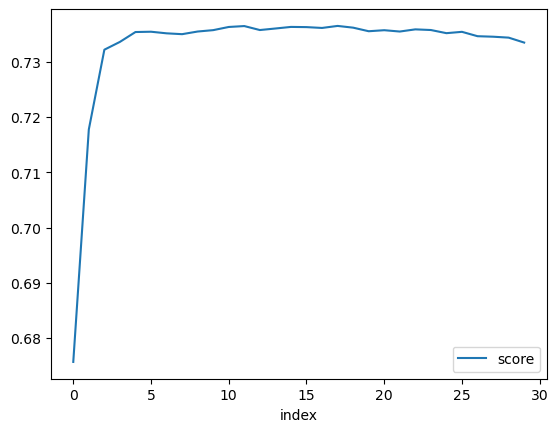

In [74]:
df_scores = pd.DataFrame({ "featch_count" : selected_features , "score" : best_scores }).reset_index()
df_scores.plot("index", "score")

In [73]:
df_scores.featch_count

0                         EXT_SOURCE_3
1                         EXT_SOURCE_2
2                         EXT_SOURCE_1
3                higher_EDUCATION_TYPE
4                           AMT_CREDIT
5     single/not_married_FAMILY_STATUS
6          REGION_RATING_CLIENT_W_CITY
7           REGION_POPULATION_RELATIVE
8                          OWN_CAR_AGE
9                          CODE_GENDER
10                    AMT_INCOME_TOTAL
11                  over_FAMILY_STATUS
12             req_credit_bureau_count
13                      month_employed
14           state_servant_INCOME_TYPE
15                     FLAG_OWN_REALTY
16                        CNT_CHILDREN
17                     DAYS_ID_PUBLISH
18               married_FAMILY_STATUS
19              REG_CITY_NOT_LIVE_CITY
20            OBS_60_CNT_SOCIAL_CIRCLE
21                 communication_count
22              DAYS_LAST_PHONE_CHANGE
23    commercial_associate_INCOME_TYPE
24        civil_marriage_FAMILY_STATUS
25        house/apartment

In [75]:
pd.Series(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'month_employed', 'higher_EDUCATION_TYPE', 'CODE_GENDER', 'AMT_CREDIT', 'REGION_RATING_CLIENT_W_CITY', 'age', 'OWN_CAR_AGE', 'communication_count', 'DAYS_ID_PUBLISH', 'working_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'state_servant_INCOME_TYPE', 'married_FAMILY_STATUS', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'REG_CITY_NOT_LIVE_CITY', 'single/not_married_FAMILY_STATUS', 'DAYS_REGISTRATION', 'civil_marriage_FAMILY_STATUS', 'LIVE_CITY_NOT_WORK_CITY', 'commercial_associate_INCOME_TYPE', 'house/apartment_HOUSING_TYPE', 'req_credit_bureau_count', 'FLAG_OWN_REALTY', 'over_FAMILY_STATUS', 'OBS_60_CNT_SOCIAL_CIRCLE'])

0                         EXT_SOURCE_3
1                         EXT_SOURCE_2
2                         EXT_SOURCE_1
3                       month_employed
4                higher_EDUCATION_TYPE
5                          CODE_GENDER
6                           AMT_CREDIT
7          REGION_RATING_CLIENT_W_CITY
8                                  age
9                          OWN_CAR_AGE
10                 communication_count
11                     DAYS_ID_PUBLISH
12                 working_INCOME_TYPE
13                    AMT_INCOME_TOTAL
14          REGION_POPULATION_RELATIVE
15           state_servant_INCOME_TYPE
16               married_FAMILY_STATUS
17              DAYS_LAST_PHONE_CHANGE
18                        CNT_CHILDREN
19              REG_CITY_NOT_LIVE_CITY
20    single/not_married_FAMILY_STATUS
21                   DAYS_REGISTRATION
22        civil_marriage_FAMILY_STATUS
23             LIVE_CITY_NOT_WORK_CITY
24    commercial_associate_INCOME_TYPE
25        house/apartment

['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'month_employed', 'higher_EDUCATION_TYPE', 'CODE_GENDER', 'AMT_CREDIT', 'REGION_RATING_CLIENT_W_CITY', 'age', 'OWN_CAR_AGE', 'communication_count', 'DAYS_ID_PUBLISH', 'working_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'state_servant_INCOME_TYPE', 'married_FAMILY_STATUS', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'REG_CITY_NOT_LIVE_CITY', 'single/not_married_FAMILY_STATUS', 'DAYS_REGISTRATION', 'civil_marriage_FAMILY_STATUS', 'LIVE_CITY_NOT_WORK_CITY', 'commercial_associate_INCOME_TYPE', 'house/apartment_HOUSING_TYPE', 'req_credit_bureau_count', 'FLAG_OWN_REALTY', 'over_FAMILY_STATUS', 'OBS_60_CNT_SOCIAL_CIRCLE']

[0.6735553462249082, 0.7158973878247935, 0.7262816922928654, 0.7301802906134205, 0.732614814759214, 0.7336394525976606, 0.7338275256682912, 0.7347426656186714, 0.7341640380720914, 0.7345976585882358, 0.7344861741221005, 0.735377227754008, 0.7345280832063174, 0.7347641144537607, 0.7341635329620426, 0.734284539269936, 0.7347227556290941, 0.7348904380560785, 0.7337296660048691, 0.7347085184862658, 0.7343817263939076, 0.7332114898784318, 0.734327842345014, 0.7341639270795668, 0.7342604576545364, 0.7346025394374782, 0.7340856303189287, 0.7345059712379239, 0.7335172498279757, 0.7346283019311965]

In [32]:
fitchs = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'month_employed',\
          'higher_EDUCATION_TYPE', 'CODE_GENDER', 'AMT_CREDIT', 'REGION_RATING_CLIENT_W_CITY',\
          'age', 'OWN_CAR_AGE', 'communication_count']

# Градиентный бустинг

In [67]:
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


gbm = GradientBoostingClassifier(random_state=42, learning_rate=0.05, max_depth=3,\
                                 max_features=None, n_estimators=300, subsample=0.8)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

gbm.fit(X_train[fitchs], y_train, sample_weights, )

roc_auc_score(y_test, gbm.predict_proba(X_test[fitchs])[:, 1])

0.7524448022417027

In [68]:
print("----------------------------")
print("Метрики на test выборке:")

calculate_and_display_metrics(y_test, gbm.predict(X_test[fitchs]))
print("ROC-AUC =", roc_auc_score(y_test, gbm.predict_proba(X_test[fitchs])[:,1]))

----------------------------
Метрики на test выборке:
Accuracy =: 0.6962
Precision =: 0.9003
Recall =: 0.6962
F1 Score =: 0.7662
ROC-AUC = 0.7524448022417027


In [70]:
print("----------------------------")
print("Метрики на train выборке:")

calculate_and_display_metrics(y_train, gbm.predict(X_train[fitchs]))
print("ROC-AUC =", roc_auc_score(y_train, gbm.predict_proba(X_train[fitchs])[:,1]))

----------------------------
Метрики на train выборке:
Accuracy =: 0.6977
Precision =: 0.9015
Recall =: 0.6977
F1 Score =: 0.7674
ROC-AUC = 0.7624971962756026
